In [1]:
# Standard library imports
from collections import Counter
import os
import random
import zipfile

# Third-party data science and machine learning imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split

# DICOM handling
import pydicom

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
)

# Torchvision imports
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights

In [2]:
if torch.cuda.is_available():
    print(f"GPUs Available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"- {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available.")

No GPUs available.


# Local

In [3]:
# ## Dataset and Directory Configuration
# DATASET_NAME = 'rsna-mil-training'
# JOB_NAME = 'RSNA-ResNet18'
# HPC_DIR = '/media02/tdhoang01/21127112-21127734/data'
# OUTPUT_DIR = '/media02/tdhoang01/python-debugging/rsna/results'

# ZIP_FILE_PATH = os.path.join(HPC_DIR, DATASET_NAME + '.zip')
# CHECKPOINTS_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'checkpoints')
# FIGURES_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'figures')
# DICOM_DIR = f'{DATASET_NAME}/'

# ## File Paths
# CSV_PATH = f'{DATASET_NAME}/training_1000_scan_subset.csv'

# ## Image Processing Parameters
# MAX_SLICES = 60
# HEIGHT = 224
# WIDTH = 224

# ## Training Hyperparameters
# BATCH_PATIENTS = 4
# NUM_EPOCHS = 2
# LEARNING_RATE = 1e-4

# ## Dataset Split Ratios
# VAL_SIZE = 0.15
# TEST_SIZE = 0.15

# ## Create Necessary Directories
# os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
# os.makedirs(FIGURES_DIR, exist_ok=True)

# ## Load CSVs from zip
# with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
#     medical_scan_data = pd.read_csv(zip_ref.open(CSV_PATH))

# Kaggle

In [4]:
# Configuration
DATASET_NAME = 'rsna-mil-training'
JOB_NAME = 'RSNA-ResNet18'
INPUT_DIR = '/kaggle/input'
OUTPUT_DIR = '/kaggle/working'

# Directories
CHECKPOINTS_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'checkpoints')
FIGURES_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'figures')
DICOM_DIR = os.path.join(INPUT_DIR, DATASET_NAME, DATASET_NAME)

# File Paths
CSV_PATH = f'{DICOM_DIR}/training_1000_scan_subset.csv'

# Image Processing Parameters
MAX_SLICES = 60
HEIGHT = 224
WIDTH = 224

# Training Hyperparameters
BATCH_PATIENTS = 32
NUM_EPOCHS = 1
LEARNING_RATE = 3e-4

# Dataset Split Ratios
VAL_SIZE = 0.15
TEST_SIZE = 0.15

# Create Necessary Directories
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Load CSV from Kaggle environment (no need to unzip)
medical_scan_data = pd.read_csv(CSV_PATH)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [5]:
medical_scan_data.head(1)

,patient_id,study_instance_uid,images,labels,patient_label,length
0,ID_2e010e33,ID_bda0f47e84,"['ID_b9035cb1e.dcm', 'ID_0713bed86.dcm', 'ID_5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,48


In [6]:
medical_scan_data.columns

Index(['patient_id', 'study_instance_uid', 'images', 'labels', 'patient_label',
       'length'],
      dtype='object')

# Data augmentation

In [7]:
class DatasetAugmentor:
    def __init__(self, height, width, seed=None):
        self.height = height
        self.width = width
        self.seed = seed
        
        # Store parameters for consistency checks with non-overlapping ranges
        self.min_params = self._create_transform(5, (0.05, 0.05), (0.95, 1.05), 
                                                  brightness_range=0.05, contrast_range=0.05,
                                                  blur_sigma_range=(0.1, 0.2), apply_elastic=False, level_name='min')
        self.med_params = self._create_transform(10, (0.1, 0.1), (0.9, 1.1), 
                                                  brightness_range=0.1, contrast_range=0.1,
                                                  blur_sigma_range=(0.2, 0.5), apply_elastic=True, level_name='med')
        self.max_params = self._create_transform(15, (0.2, 0.2), (0.8, 1.2), 
                                                  brightness_range=0.2, contrast_range=0.2,
                                                  blur_sigma_range=(0.5, 1.0), apply_elastic=True, level_name='max')

    def _sample_value(self, value_range):
        if isinstance(value_range, tuple):
            random.seed(self.seed)
            return random.uniform(value_range[0], value_range[1])
        return value_range

    def _create_transform(self, degrees, translate_range, scale_range,
                      brightness_range, contrast_range,
                      blur_sigma_range, apply_elastic, level_name):
        print(f"Creating '{level_name}' transform with parameters:")

        # Sample specific values and take the absolute value for positivity
        sampled_degrees = abs(self._sample_value((-degrees, degrees)) if isinstance(degrees, int) else degrees)
        sampled_translate_x = abs(self._sample_value(translate_range[0]))
        sampled_translate_y = abs(self._sample_value(translate_range[1]))
        sampled_scale = self._sample_value(scale_range)
        sampled_brightness = self._sample_value(brightness_range)
        sampled_contrast = self._sample_value(contrast_range)
        sampled_blur_sigma = self._sample_value(blur_sigma_range)

        # Print specific sampled values
        print(f"  Degrees: {sampled_degrees}, Translate: ({sampled_translate_x}, {sampled_translate_y}), Scale: {sampled_scale}")
        print(f"  Brightness: {sampled_brightness}, Contrast: {sampled_contrast}")
        print(f"  Blur Sigma: {sampled_blur_sigma}, Apply Elastic: {apply_elastic}")

        return {
            "degrees": sampled_degrees,
            "translate": (sampled_translate_x, sampled_translate_y),
            "scale": sampled_scale,
            "brightness": sampled_brightness,
            "contrast": sampled_contrast,
            "blur_sigma": sampled_blur_sigma,
            "apply_elastic": apply_elastic
        }

    def apply_transform(self, image, level):        
        if self.seed is not None:
            torch.manual_seed(self.seed)
            random.seed(self.seed)

        if level == 0:
            params = self.min_params
            transform = self._get_transform(params)
        elif level == 1:
            params = self.med_params
            transform = self._get_transform(params)
        else:
            params = self.max_params
            transform = self._get_transform(params)

        transformed_image = transform(image)        
        return transformed_image

    def _get_transform(self, params):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=params["degrees"], translate=params["translate"], scale=(params["scale"], params["scale"])),
            transforms.ColorJitter(brightness=params["brightness"], contrast=params["contrast"]),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=params["blur_sigma"]),
            transforms.RandomApply([transforms.ElasticTransform()] if params["apply_elastic"] else [], p=0.3),
            transforms.Resize((self.height, self.width)),
            transforms.ToTensor(),
            transforms.RandomApply([self._channel_shuffle], p=0.3)
        ])

    def _channel_shuffle(self, tensor):
        channels = tensor.shape[0]
        indices = torch.randperm(channels)
        print(f"Channel shuffle indices: {indices.tolist()}")
        return tensor[indices]

In [8]:
augmentor = DatasetAugmentor(HEIGHT, WIDTH, seed=42)

Creating 'min' transform with parameters:
  Degrees: 1.3942679845788373, Translate: (0.05, 0.05), Scale: 1.0139426798457885
  Brightness: 0.05, Contrast: 0.05
  Blur Sigma: 0.16394267984578836, Apply Elastic: False
Creating 'med' transform with parameters:
  Degrees: 2.7885359691576745, Translate: (0.1, 0.1), Scale: 1.027885359691577
  Brightness: 0.1, Contrast: 0.1
  Blur Sigma: 0.3918280395373651, Apply Elastic: True
Creating 'max' transform with parameters:
  Degrees: 4.182803953736514, Translate: (0.2, 0.2), Scale: 1.0557707193831534
  Brightness: 0.2, Contrast: 0.2
  Blur Sigma: 0.8197133992289418, Apply Elastic: True


# Local dataset gen.

# Kaggle dataset gen.

In [9]:
class MedicalScanDataset(Dataset):
    def __init__(self, dicom_dir, medical_scan_data, max_slices, height, width, augmentor, balance_dataset=False):
        self.dicom_dir = dicom_dir
        self.medical_scan_data = self._parse_medical_scan_data(medical_scan_data)
        self.max_slices = max_slices
        self.height = height
        self.width = width
        self.augmentor = augmentor
        self.dicom_paths, self.all_labels = self._get_dicom_paths_and_labels()

        if balance_dataset:
            self._balance_dataset()

    def __len__(self):
        return len(self.dicom_paths) * 3

    def __getitem__(self, idx, apply_transform=True):
        orig_idx = idx // 3
        transform_idx = idx % 3

        dicom_file, label = self.dicom_paths[orig_idx], self.all_labels[orig_idx]
        images = self._process_dicom_file(dicom_file)

        if apply_transform:
            transformed_img = self.augmentor.apply_transform(images, transform_idx)
        else:
            transformed_img = images

        labels = torch.tensor(label, dtype=torch.float32)
        return transformed_img, labels

    def _parse_medical_scan_data(self, medical_scan_data):
        medical_scan_data['images'] = medical_scan_data['images'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        medical_scan_data['labels'] = medical_scan_data['labels'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        return medical_scan_data

    def _get_dicom_paths_and_labels(self):
        dicom_paths = []
        labels = []

        for _, row in self.medical_scan_data.iterrows():
            patient_id = row['patient_id'].replace("ID_", "")
            study_instance_uid = row['study_instance_uid'].replace("ID_", "")
            dicom_dir_path = os.path.join(self.dicom_dir, f"{patient_id}_{study_instance_uid}")

            if os.path.exists(dicom_dir_path):
                for image, label in zip(row['images'], row['labels']):
                    dicom_file_path = os.path.join(dicom_dir_path, image)
                    if os.path.exists(dicom_file_path):
                        dicom_paths.append(dicom_file_path)
                        labels.append(label)
            else:
                print(f"DICOM directory does not exist: {dicom_dir_path}")

        return dicom_paths, labels

    def _balance_dataset(self):
        label_counter = Counter(self.all_labels)
        min_class_count = min(label_counter[0], label_counter[1])

        dicom_pairs_0 = [(path, label) for path, label in zip(self.dicom_paths, self.all_labels) if label == 0]
        dicom_pairs_1 = [(path, label) for path, label in zip(self.dicom_paths, self.all_labels) if label == 1]

        random.shuffle(dicom_pairs_0)
        random.shuffle(dicom_pairs_1)

        dicom_pairs_0 = dicom_pairs_0[:min_class_count]
        dicom_pairs_1 = dicom_pairs_1[:min_class_count]

        balanced_pairs = dicom_pairs_0 + dicom_pairs_1
        random.shuffle(balanced_pairs)

        self.dicom_paths, self.all_labels = zip(*balanced_pairs)

    def _process_dicom_file(self, dicom_file):
        dicom = pydicom.dcmread(dicom_file)
        img = self._preprocess_slice(dicom)
        return torch.from_numpy(img).float()

    def _preprocess_slice(self, dicom):
        return self._bsb_window(dicom).astype(np.float16)

    def _bsb_window(self, dcm):
        brain_img = self._window_image(dcm, 40, 80)
        subdural_img = self._window_image(dcm, 80, 200)
        soft_img = self._window_image(dcm, 40, 380)

        brain_img_normalized = (brain_img - 0) / 80
        subdural_img_normalized = (subdural_img - (-20)) / 200
        soft_img_normalized = (soft_img - (-150)) / 380

        return np.stack([brain_img_normalized, subdural_img_normalized, soft_img_normalized], axis=0)

    def _window_image(self, dcm, window_center, window_width):
        img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        return cv2.resize(img, (self.height, self.width), interpolation=cv2.INTER_LINEAR)

In [10]:
medical_scan_dataset = MedicalScanDataset(
    dicom_dir=DICOM_DIR,
    medical_scan_data=medical_scan_data,
    max_slices=MAX_SLICES,
    height=HEIGHT,
    width=WIDTH,
    augmentor=augmentor,
    balance_dataset=True
)

In [11]:
images, labels = medical_scan_dataset[0]
print("Shape of image tensor:", images.shape)
print("Label:", labels)

Shape of image tensor: torch.Size([3, 224, 224])
Label: tensor(0.)


In [12]:
print(len(medical_scan_dataset))

36534


# Plot original vs augmented data

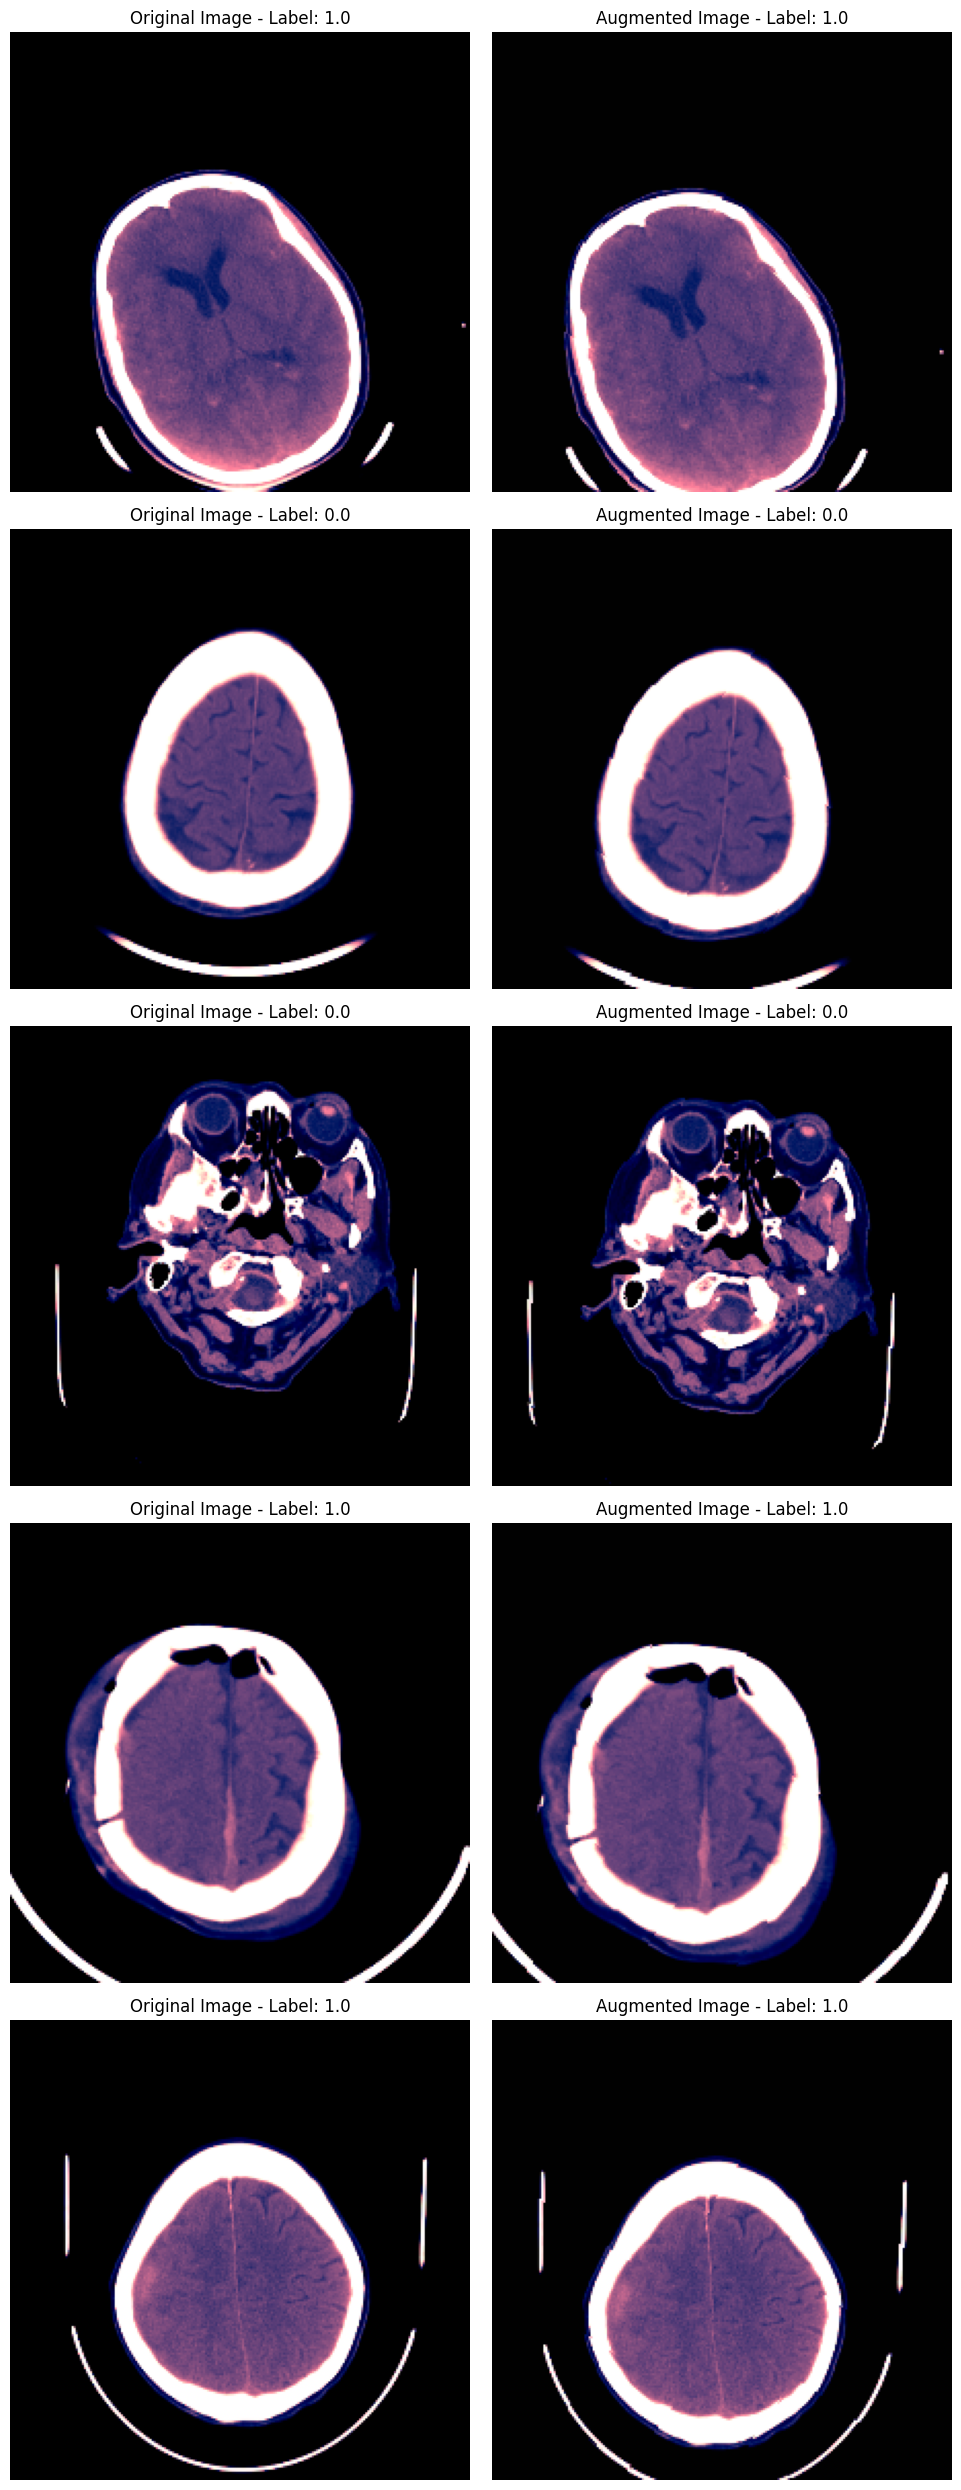

In [13]:
def show_multiple_original_and_augmented(dataset, num_images=5):
    indices = random.sample(range(len(dataset) // 3), num_images)
    
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    
    for i, idx in enumerate(indices):
        original_image, label = dataset.__getitem__(idx * 3, apply_transform=False)
        augmented_image, _ = dataset.__getitem__(idx * 3, apply_transform=True)

        original_image_np = original_image.permute(1, 2, 0).numpy()
        augmented_image_np = augmented_image.permute(1, 2, 0).numpy()

        axes[i, 0].imshow(np.clip(original_image_np, 0, 1))
        axes[i, 0].set_title(f'Original Image - Label: {label.item()}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.clip(augmented_image_np, 0, 1))
        axes[i, 1].set_title(f'Augmented Image - Label: {label.item()}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
    
show_multiple_original_and_augmented(medical_scan_dataset, num_images=5)

# Dataloader

In [14]:
class DataloaderManager:
    def __init__(self, dataset, val_size, test_size, batch_size, num_workers=4):
        self.dataset = dataset
        self.val_size = val_size
        self.test_size = test_size
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_loader, self.validate_loader, self.test_loader = self._create_loaders()

    def _split_indices(self):
        labels = self.dataset.all_labels
        indices = np.arange(len(labels) * 3)

        original_labels = np.repeat(labels, 3)
        train_val_indices, test_indices = train_test_split(
            indices, test_size=self.test_size, stratify=original_labels, random_state=42
        )

        val_relative_size = self.val_size / (1 - self.test_size)
        train_indices, val_indices = train_test_split(
            train_val_indices, test_size=val_relative_size, stratify=original_labels[train_val_indices], random_state=42
        )

        return train_indices, val_indices, test_indices

    def _create_dataloader(self, indices, shuffle=True):
        return DataLoader(
            Subset(self.dataset, indices), batch_size=self.batch_size, shuffle=shuffle,
            num_workers=self.num_workers, pin_memory=True
        )

    def _create_loaders(self):
        train_indices, val_indices, test_indices = self._split_indices()
        train_loader = self._create_dataloader(train_indices, shuffle=True)
        validate_loader = self._create_dataloader(val_indices, shuffle=False)
        test_loader = self._create_dataloader(test_indices, shuffle=False)
        return train_loader, validate_loader, test_loader

In [15]:
dataloader_manager = DataloaderManager(medical_scan_dataset, val_size=VAL_SIZE, test_size=TEST_SIZE, batch_size=BATCH_PATIENTS)

# Model configurations

In [16]:
# 2. Model Definition
class ResNet18(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.dropout = nn.Dropout(p=0.3)  # Add dropout layer

    def forward(self, x):
        return self.dropout(self.resnet(x))
    
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.6MB/s]


In [ ]:
# 3. Loss and Optimizer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

# mode: Monitors 'min' or 'max' changes in metrics.
# factor: The multiplicative factor for reducing the learning rate. 
##  If the current learning rate is 0.01 and factor=0.5, the new learning rate will be 0.01 * 0.5 = 0.005
# patience: Number of epochs to wait for improvement before reducing the learning rate.

In [ ]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)

        # Forward pass
        optimizer.zero_grad()
        output = model(image).squeeze()
        label = label.reshape(-1)
        
        loss = criterion(output, label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

        # Calculate accuracy
        predicted_label = (output > 0.5).float()
        total += label.size(0)
        correct += (predicted_label == label).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}%')

    scheduler.step(epoch_loss)
    return epoch_loss

In [ ]:
def validate(model, validate_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for batch_idx, (image, label) in enumerate(validate_loader):
            image, label = image.to(device), label.to(device)
            
            # Forward pass
            output = model(image).squeeze()
            label = label.reshape(-1)
            
            loss = criterion(output, label)
            running_loss += loss.item()
            
            # Calculate accuracy
            predicted_label = (output > 0.5).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()
    
    # Calculate average loss and accuracy for validation
    val_loss = running_loss / len(validate_loader)
    accuracy = 100 * correct / total
    
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}%')
    
    return val_loss

In [ ]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss):
    checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'checkpoint_epoch_{epoch+1}.pth')    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

In [ ]:
def load_best_checkpoint(model, optimizer, scheduler, checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch_') and f.endswith('.pth')]
    if not checkpoint_files:
        print("No checkpoints found.")
        return None, None

    best_checkpoint = min(checkpoint_files, key=lambda x: float(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint)
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device(device), weights_only=True)
    except RuntimeError as e:
        print(f"Error loading checkpoint: {e}")
        print(f"Checkpoint file: {checkpoint_path}")
        print(f"File size: {os.path.getsize(checkpoint_path)} bytes")
        return None, None

    try:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        epoch = checkpoint['epoch']
        best_val_loss = checkpoint['loss']
        
        print(f"Loaded checkpoint from epoch {epoch+1} with validation loss {best_val_loss}")
        
        return epoch, best_val_loss
    except KeyError as e:
        print(f"Error: Checkpoint file is missing expected data: {e}")
        print(f"Available keys in checkpoint: {checkpoint.keys()}")
        return None, None

In [ ]:
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve.png'))
    plt.show()
    plt.close()

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix.png'))
    plt.show()
    plt.close()

In [ ]:
def save_final_model(model, optimizer, scheduler, final_model_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, final_model_path)
    print(f"Final model saved to {final_model_path}")

In [ ]:
def evaluate(model, test_loader, device, criterion):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_scores = []
    test_loss = 0

    with torch.inference_mode():
        for image, label in test_loader:
            image, label = image.to(device), label.to(device)
            
            output = model(image).squeeze()
            label = label.reshape(-1)
            
            loss = criterion(output, label)
            test_loss += loss.item()
            
            predicted_label = (output > 0.5).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()
            
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted_label.cpu().numpy())
            all_scores.extend(output.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f'Test Accuracy: {accuracy:.4f}%')
    print(f'Test Loss: {avg_loss:.4f}')
    
    plot_roc_curve(np.array(all_labels), np.array(all_scores))
    plot_confusion_matrix(np.array(all_labels), np.array(all_predictions))

    return accuracy, avg_loss

# Main

## Train result

In [ ]:
loaded_epoch, loaded_best_val_loss = load_best_checkpoint(model, optimizer, scheduler, CHECKPOINTS_DIR)

if loaded_epoch is not None:
    start_epoch = loaded_epoch + 1
    best_val_loss = loaded_best_val_loss
else:
    start_epoch = 0
    best_val_loss = float('inf')

for epoch in range(start_epoch, NUM_EPOCHS):
    train_loader = dataloader_manager.train_loader
    validate_loader = dataloader_manager.validate_loader 
    
    train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss = validate(model, validate_loader, criterion, device)
    
    if val_loss < best_val_loss:
        save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
        best_val_loss = val_loss

## Evaluate result

In [ ]:
test_loader = dataloader_manager.test_loader
accuracy, test_loss = evaluate(model, test_loader, device, criterion)

final_model_path = os.path.join(CHECKPOINTS_DIR, 'final_model.pth')
save_final_model(model, optimizer, scheduler, final_model_path)